In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import old_ram_model as ram_model
import plotting

### To do:

create a RAT, RA, RT dataset each, then run through a notebook to look at the results

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds, nlevels = 95)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
co2_lev = ds.CO2_list.values

Dropped levels [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 20, 22, 24, 26]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [4]:
timestep = 300 #seconds

############# FIND OUR AVERAGE KAPPA AND ADVECTION ###############

#### Find the surface diffk average over 12 months at CO2 = .00038 ####
mean_diffk_dict = {}
mean_diffk_dict = ram_model.fill_ensemble(ds, mean_diffk_dict, timestep, 
                                                     advection_on = True, turbulence_on = True, 
                                                     advection = None, 
                                                     surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, mean_diffk_dict)
print(surface_diffk_average)

#### Find our initial advection #### 
adv_dict = {}
adv_dict = ram_model.fill_ensemble(ds, adv_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = None, 
                                   surface_diffk = surface_diffk_average)
advection_380_monthly = {}
for m in months:
    advection_380_monthly[m] = adv_dict[0.00038][m].subprocess.Advection.forcing_tendencies['Tatm']
    
############# CREATE OUR MODELS ############    
#### Use our initial advection and surface diffk to run the model #### 

########### RADIATIVE ADVECTIVE TURBULENT #############
rat_dict = {}
rat_dict = ram_model.fill_ensemble(ds, rat_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



[0.28834624]


In [5]:
########### RADIATIVE ADVECTIVE #############
ra_dict = {}
ra_dict = ram_model.fill_ensemble(ds, ra_dict, timestep, 
                                   advection_on = True, turbulence_on = False, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



In [6]:
########### RADIATIVE TURBULENT #############
rt_dict = {}
rt_dict = ram_model.fill_ensemble(ds, rt_dict, timestep, 
                                   advection_on = False, turbulence_on = True, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

In [7]:
########### RADIATIVE TURBULENT #############
r_dict = {}
r_dict = ram_model.fill_ensemble(ds, r_dict, timestep, 
                                   advection_on = False, turbulence_on = False, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

# Output (initial and over time)

In [8]:
month_ds_dict = {} #Empty dictionary to add values into
steps = 43201
fields_dict = {'TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds'}
model_dict = {'rat':rat_dict,
             'rt':rt_dict,
             'ra':ra_dict,
             'r':r_dict}

In [9]:
#original
ex_dict = rat_dict.copy()
save_freq = 288
for month in months:
    month_ds_dict[month] = xr.Dataset(data_vars = {
                                    'model' : ('model', ['rat','rt','ra','r']),
                                    'co2_lev': ('co2_lev', ds['CO2_list'].values), 
                                    'time': ('time', np.arange(0,((steps+1)*timestep),save_freq*timestep)),
                                    'lev': ('lev', ex_dict[.00038][month].lev),
                                    'lev_full': ('lev_full', np.append(ex_dict[.00038][month].lev, 
                                                                       ex_dict[.00038][month].lev[-1]+(ex_dict[.00038][month].lev[-1]-ex_dict[.00038][month].lev[-2]))),
                                    'lev_bounds': ('lev_bounds', ex_dict[.00038][month].lev_bounds)
                                    })
    lev_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'],month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev','time')
                    )


    lev_bounds_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_bounds'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_bounds'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_bounds','time')
                    )
    lev_full_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_full'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_full'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_full','time')
                    )
    month_ds_dict[month]['T'] = lev_full_da.copy()
    month_ds_dict[month]['turb_hr'] = lev_full_da.copy()
    month_ds_dict[month]['turbulent_flux'] = lev_bounds_da.copy()
    month_ds_dict[month]['diffk'] = lev_bounds_da.copy()
    month_ds_dict[month]['theta_init'] = lev_da.copy()
    month_ds_dict[month]['theta'] = lev_da.copy()
    month_ds_dict[month]['turb_atm_hr'] = lev_da.copy()
    month_ds_dict[month]['advection'] = lev_full_da.copy()
    month_ds_dict[month]['heat_capacity'] = lev_da.copy()
    
    for var in fields_dict.keys():
        if fields_dict[var] == 'z':
            month_ds_dict[month][var] = lev_da.copy()
        if fields_dict[var] == 'z_bounds':
            month_ds_dict[month][var] = lev_bounds_da.copy()
            
    for co2 in ex_dict.keys():
        for dict_name in model_dict.keys():
            #create z coords
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z = ex_dict[co2][month].z)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_bounds = ex_dict[co2][month].z_bounds)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_full = np.append(ex_dict[co2][month].z, 0))
            
            month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].state['Ts']))
            month_ds_dict[month]['heat_capacity'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].domains['Tatm'].heat_capacity

            
            if 'a' in dict_name:
                month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
            
            if 't' in dict_name:
                month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data

            for var in fields_dict.keys():
                month_ds_dict[month][var].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


In [ ]:
#timestepper
for month in months:
    for dict_name in model_dict.keys():
        for co2 in rat_dict.keys():
            for i in range(1,steps):
                #step the model forward
                model_dict[dict_name][co2][month].step_forward()
                if i*timestep in month_ds_dict[month]['time']:
                    #assign temperature
                    month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                                 np.array(model_dict[dict_name][co2][month].state['Ts']))
                    #assign heat capacity
                    month_ds_dict[month]['heat_capacity'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].domains['Tatm'].heat_capacity
                    #assign the variables in the 'field dict' which are typical outputs from climlab
                    for var in fields_dict.keys():

                        month_ds_dict[month][var].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


                    #assign the variables in the 'advection' field
                    if 'a' in dict_name:

                        month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                                 np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
                    #assign the variables in the 'turbulence field'
                    if 't' in dict_name:

                        month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                                     np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                        month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                                     np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                        month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                                     np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                        month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                        month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                        month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = ((i)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data



In [13]:
for month in months:
    month_ds_dict[month].to_netcdf(f'./output/{month}_orig_43200ts_ds')

In [34]:
###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','turb_atm_hr':'z', 
               'turb_hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'turb_atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)',
                   'atm_turbulent_flux':'Turbulent Flux'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux':r'Total Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_near_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'turb_sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation ($\frac{W}{m^2}$)'}

#### parameters for plots

In [15]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = 1*timestep
time3 = 2*timestep
time4 = 5*timestep
time5 = 7*timestep
time6 = 9*timestep
time7 = 12*timestep
time8 = 15*timestep
time9 = 18*timestep
time10 = 200*timestep

month1 = 'December'
month2 = 'April'

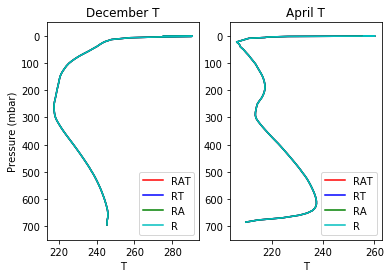

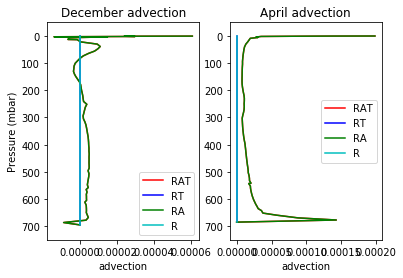

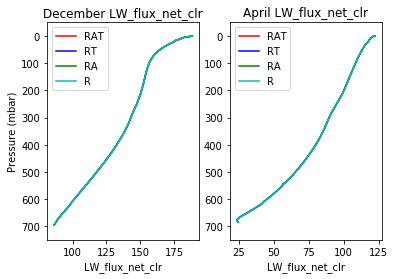

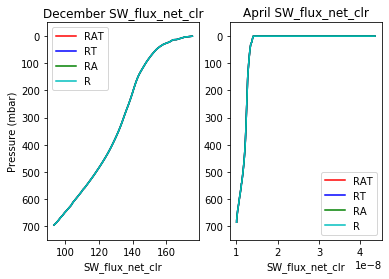

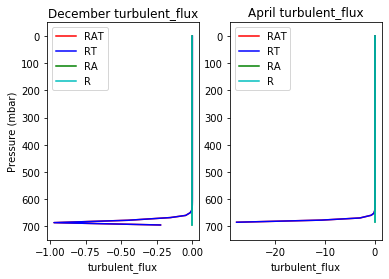

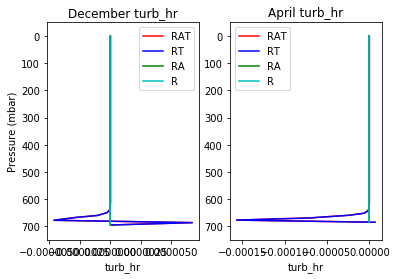

In [16]:
time = 0
for output in ['T','advection', 'LW_flux_net_clr', 'SW_flux_net_clr', 'turbulent_flux', 'turb_hr']:
    fig, axes = plt.subplots(1, 2)
    for idx, month in enumerate([month1, month2]):
        ax = axes[idx]
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)['lev_full'], 
                color = 'r',
                label = 'RAT'
               )
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)['lev_full'], 
                color = 'b',
                label = 'RT')
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)['lev_full'], 
                color = 'g',
                label = 'RA')
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'r', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'r', time = time)['lev_full'], 
                color = 'c',
                label = 'R')
        ax.legend()
        ax.set_xlabel(output)
        axes[0].set_ylabel('Pressure (mbar)')
        ax.set_ylim([750,-50])
        ax.set_title(month + ' ' + output)

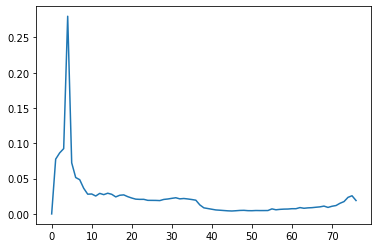

In [35]:
plt.plot(rat_dict[0]['January'].subprocess.Turbulence.diagnostics['dtheta_dz'])

In [17]:
month_ds_dict['April'].isel(co2_lev = 0).sel(model = 'rat')['lev_bounds'][-1].values-month_ds_dict['April'].isel(co2_lev = 0).sel(model = 'rat')['lev_bounds'][-2].values

7.839999999999918

### find entire column energy balance

In [30]:
#time we're looking at
time = month_ds_dict['January']['time'][-2]
month = month1
co2 = 0.00038

In [31]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[ds.month.values, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [33]:
for idx_month, month in enumerate(ds.month.values):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).values.sum()
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time+save_freq*timestep))['T'].values - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time))['T'].values)[:-1]/save_freq*timestep * month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] + 
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

In [34]:
energy_budget_df

ATM_mass              TOA_rad  \
month     model                                            
January   rat     7085831.885510202   -28.09013273534569   
          ra      7085831.885510202  -28.057484856383667   
          rt      7085831.885510202  -1.7810973722345693   
          r       7085831.885510202  -1.9624809057888797   
February  rat     7052158.135306121   -67.46417789154555   
          ra      7052158.135306121   -65.61960034648348   
          rt      7052158.135306121   -6.095587327374545   
          r       7052158.135306121   -6.113360812185078   
March     rat    7017852.7359183645  -112.18858475431551   
          ra     7017852.7359183645  -109.63418368396619   
          rt     7017852.7359183645  -20.417889753411387   
          r      7017852.7359183645  -20.226399708816018   
April     rat     6976434.508775509  -125.37353472665707   
          ra      6976434.508775509   -119.8628211764512   
          rt      6976434.508775509                  nan   
          r       6976434.508775509                  nan   
May       rat     6982615.819183674  -111.88504047556152   
          ra      6982615.819183674  -108.65090007924245   
          rt      6982615.819183674                  nan   
          r       6982615.819183674                  nan   
June      rat     7018350.945306123   -111.5525465286928   
          ra      7018350.945306123    -108.858703676122   
          rt      7018350.945306123                  nan   
          r       7018350.945306123                  nan   
July      rat     6972969.376938776  -106.06348122161215   
          ra      6972969.376938776  -103.74658344909813   
          rt      6972969.376938776                  nan   
          r       6972969.376938776                  nan   
August    rat     6958588.511224489   -105.3850958370541   
          ra      6958588.511224489     -102.86354380541   
          rt      6958588.511224489                  nan   
          r       6958588.511224489                  nan   
September rat     6980780.343265304  -111.61934097043081   
          ra      6980780.343265304  -108.64553899009789   
          rt      6980780.343265304   -25.34367580549643   
          r       6980780.343265304   -25.11669138848943   
October   rat     6966499.570204082   -73.43203449066692   
          ra      6966499.570204082   -70.93737911166178   
          rt      6966499.570204082   -9.237149633474303   
          r       6966499.570204082   -9.168406686819665   
November  rat     7030595.391224489   -35.17701671767392   
          ra      7030595.391224489  -34.281653866118916   
          rt      7030595.391224489   -2.156520601166818   
          r       7030595.391224489  -2.3301346995957317   
December  rat     7073979.819183674   -20.05443693185279   
          ra      7073979.819183674  -20.172643982387683   
          rt      7073979.819183674  -0.8291503957645148   
          r       7073979.819183674  -1.0742058063658817   

                               SFC_rad             SFC_turb  ATM_adv  \
month     model                                                        
January   rat      -0.4939565413153275  -0.5038050134239634  28.0896   
          ra       0.01006574837654739                  0.0  28.0896   
          rt        0.6412588621054454   1.0803653601178025        0   
          r       -0.42853986456063353                  0.0        0   
February  rat       -12.27686936583909  -12.377039894495606  65.8667   
          ra       0.09558528396379984                  0.0  65.8667   
          rt       -1.6849000093996125  0.05619990390618702        0   
          r         -1.715994601456316                  0.0        0   
March     rat      -23.845634602763724  -23.875624058620804  109.657   
          ra     0.0032677766077782167                  0.0  109.657   
          rt       -10.063458194695421  -1.4187154862288889        0   
          r         -8.700159825116732                  0.0        0   
April     rat     

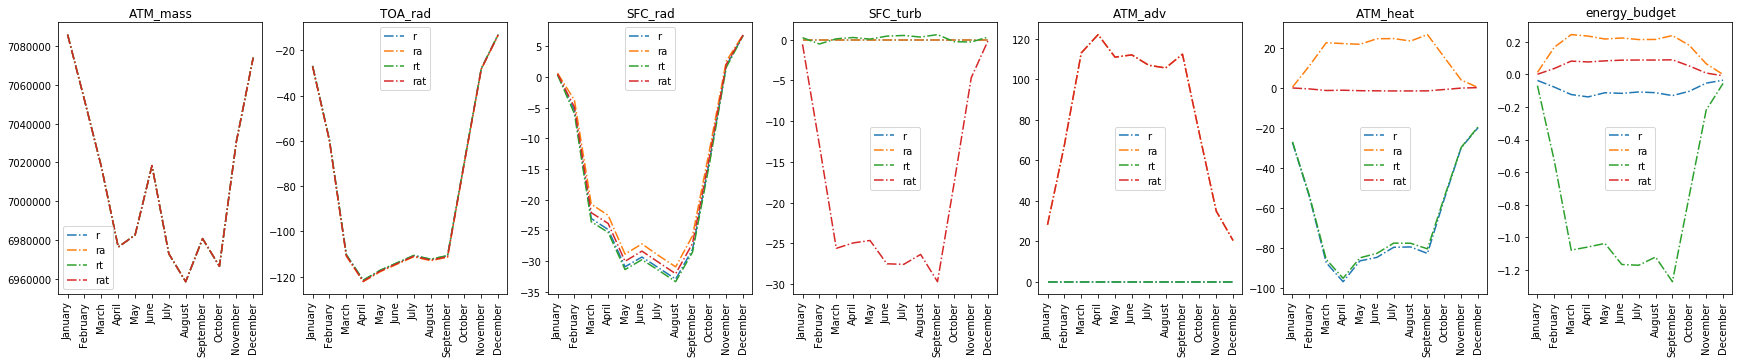

In [43]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

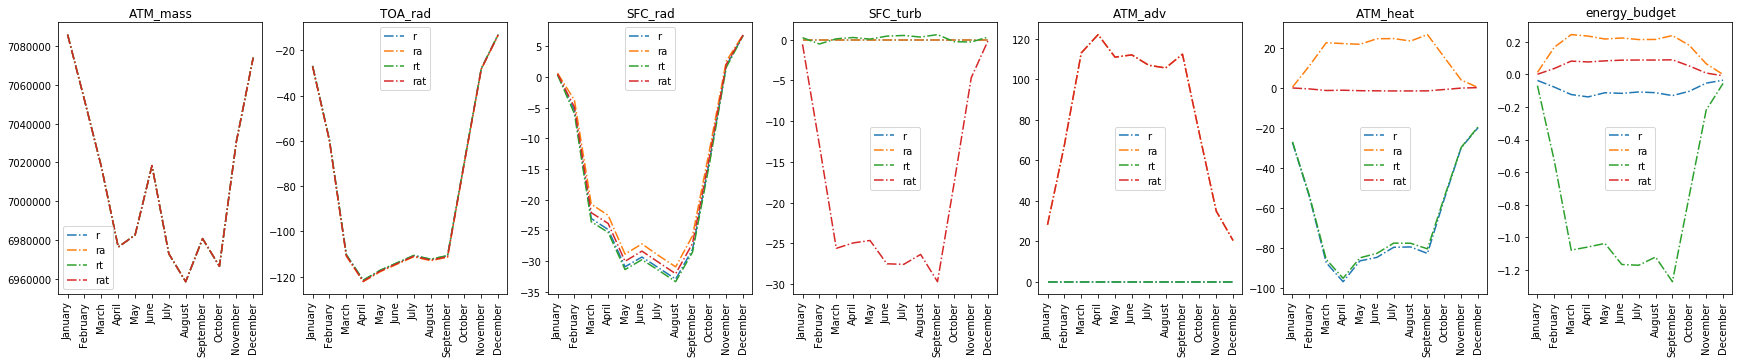

In [44]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

#### plot ASR and OLR over time

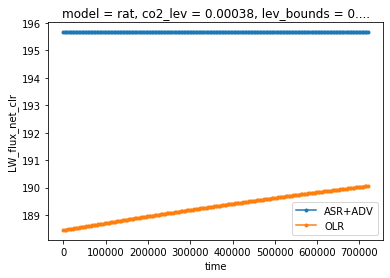

In [45]:
(month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']).plot(marker = '.', label = 'ASR+ADV')
month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['LW_flux_net_clr'][0].plot(marker = '.', label = 'OLR')
plt.legend()

#### plot the temperature difference between double and normal CO2 scenario

In [55]:
month = 'June'

(700, -50)

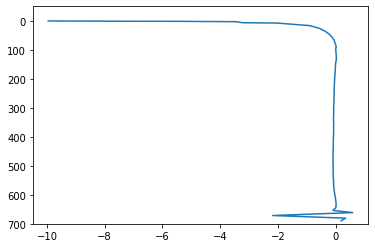

In [56]:
plt.plot((month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00076, time = 200*3600)['T'] - month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00038, time = 200*3600)['T']), month_ds_dict[month]['lev_full'])
plt.ylim(700,-50)

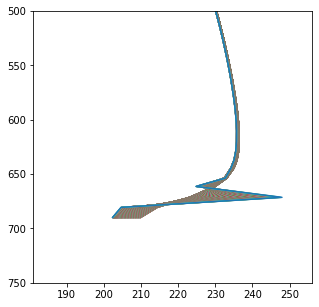

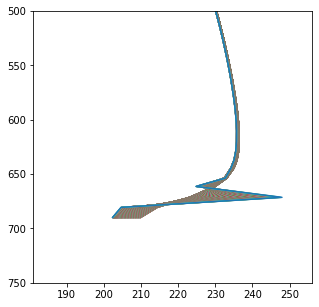

In [57]:
for co2 in [.00038,.00076]:
    fig, ax = plt.subplots(figsize = [5,5])
    for t in month_ds_dict[month]['time'].values:
        plt.plot(month_ds_dict[month].sel(
            model = 'rat', co2_lev = .00038, time = t)['T'],  month_ds_dict[month]['lev_full'])
        plt.ylim(750,500)

#### solar insolation

#### absorption coefficients and pressure

In [215]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [207]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [259]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


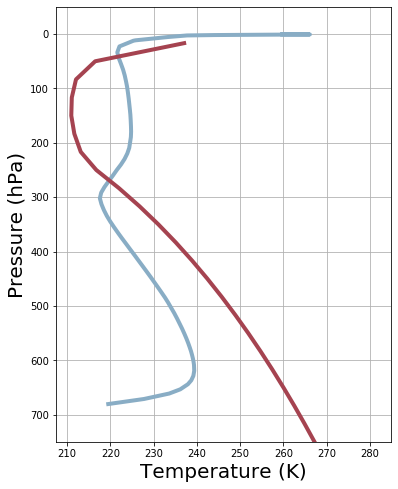

In [263]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

In [ ]:
for month in months:
    for co2 in co2_lev:
        for time in np.arange(0,((steps+1)*timestep),timestep):
            for model in model_dict.keys():
                
                #TOA Frad
                month_ds_dict[month]['F_rad_toa'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

                #Surface Frad
                month_ds_dict[month]['F_rad_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                #Surface Fturb
                month_ds_dict[month]['F_turb_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                month_ds_dict[month]['F_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = model_dict[model][F_rad_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)] - model_dict[model][F_turb_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)]
                #dT/dt
                month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                                np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

                #dz
                month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

                #heat capacity (density*cp)
                month_ds_dict[month]['R'] = 8.314 #J/mol/K
                month_ds_dict[month]['MW_air'] = 0.0289647 #kg/mol
                month_ds_dict[month]['pressure_TOA'] = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
                month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = (month_ds_dict[month]['MW_air']*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['R']) #kg/m^3
                month_ds_dict[month]['cp_air'] = 1003 #specific heat of air (at 250 K) J/(kg*K)
                month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)]*month_ds_dict[month]['cp_air']

                #atmospheric heat content rate at each level
                month_ds_dict[month]['total_atm_heat_content_rate'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2

                #advective flux at each level
                month_ds_dict[month]['total_adv_flux'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2
                
                